In [1]:
%matplotlib inline
%env PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/Montage/bin

env: PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/Montage/bin


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import sys
import time
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import theano
import theano.tensor as T

import lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum
from lasagne.objectives import squared_error
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import BatchIterator

from sklearn import neighbors
from sklearn.cross_validation import train_test_split
from sklearn.utils import check_random_state

from astropy.io import fits
from astropy import wcs

### Loading data ###
Below, the notebook loads the training and testing data into the notebook.  Since there is so much data, the act of loading must be done carefully and in pieces, or else a memory error crops up due to lack of memory (RAM).  This might be avoided in the future by having more RAM on the VM (currently sitting at 8GB and just did a successful loading with a 45722 galaxy sample).  

The splitting is currently done in make_Xy_array.ipynb which should be located in the same directory as this notebook.

In [3]:
savedir = "../data1/volue/split/"
traindir = "../data1/volue/train/"

In [4]:
y_train = np.load(traindir +"y_train.npy")
y_test = np.load(traindir +"y_test.npy")

print(y_train.shape)
print(y_test.shape)

(67082, 1)
(16770, 1)


In [5]:
X_ex = np.load(traindir+"X_test.npz")
namelist = X_ex.zip.namelist()
X_ex.zip.extract(namelist[0])
X_test = np.load(namelist[0], mmap_mode='r+')
print(X_test.shape)

(16770, 5, 48, 48)


In [7]:
X_ex = np.load(traindir+"X_train.npz")
namelist = X_ex.zip.namelist()
X_ex.zip.extract(namelist[0])
X_train = np.load(namelist[0], mmap_mode='r+')
print(X_train.shape)

(67082, 5, 48, 48)


In [8]:
print("X_train.shape = {}, X.min = {}, X.max = {}".format(X_train.shape, X_train.min(), X_train.max()))
print("y_train.shape = {}, y.min = {}, y.max = {}".format(y_train.shape, y_train.min(), y_train.max()))
print(type(y_test))
print(type(X_test))

X_train.shape = (67082, 5, 48, 48), X.min = 10.781736526640612, X.max = 29.2283795469257
y_train.shape = (67082, 1), y.min = -0.0024597, y.max = 1.456054
<class 'numpy.ndarray'>
<class 'numpy.core.memmap.memmap'>


In [9]:
def renormalize(array):
    return (array - array.min()) / (array.max() - array.min())

for i in range(5):
    X_train[:, i, :, :] = renormalize(X_train[:, i, :, :])
    
y_train = renormalize(y_train)     #maybe this shouldn't be renormalized, since we need to have this be the true value?
#y_train = np.asarray(y_train)
#X_train = np.asarray(X_train)
#y_test = np.asarray(y_test)
#X_test = np.asarray(X_test)
print("X.shape = {}, X.min = {}, X.max = {}".format(X_train.shape, X_train.min(), X_train.max()))
print("y.shape = {}, y.min = {}, y.max = {}".format(y_train.shape, y_train.min(), y_train.max()))

X.shape = (67082, 5, 48, 48), X.min = 0.0, X.max = 1.0
y.shape = (67082, 1), y.min = 0.0, y.max = 1.0


In [10]:
def compute_PCA(array):

    nimages0, nchannels0, height0, width0 = array.shape
    rolled = np.transpose(array, (0, 2, 3, 1))
    # transpose from N x channels x height x width  to  N x height x width x channels
    nimages1, height1, width1, nchannels1 = rolled.shape
    # check shapes
    assert nimages0 == nimages1
    assert nchannels0 == nchannels1
    assert height0 == height1
    assert width0 == width1
    # flatten
    reshaped = rolled.reshape(nimages1 * height1 * width1, nchannels1)
    
    from sklearn.decomposition import PCA
    
    pca = PCA()
    pca.fit(reshaped)
    
    cov = pca.get_covariance()
    
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    
    return eigenvalues, eigenvectors

In [11]:
class AugmentedBatchIterator(BatchIterator):
    
    def __init__(self, batch_size, crop_size=8, testing=False):
        super(AugmentedBatchIterator, self).__init__(batch_size)
        self.crop_size = crop_size
        self.testing = testing

    def transform(self, Xb, yb):

        Xb, yb = super(AugmentedBatchIterator, self).transform(Xb, yb)
        batch_size, nchannels, width, height = Xb.shape
        
        if self.testing:
            if self.crop_size % 2 == 0:
                right = left = self.crop_size // 2
            else:
                right = self.crop_size // 2
                left = self.crop_size // 2 + 1
            X_new = Xb[:, :, right: -left, right: -left]
            return X_new, yb

        eigenvalues, eigenvectors = compute_PCA(Xb)

        # Flip half of the images horizontally at random
        indices = np.random.choice(batch_size, batch_size // 2, replace=False)        
        Xb[indices] = Xb[indices, :, :, ::-1]

        # Crop images
        X_new = np.zeros(
            (batch_size, nchannels, width - self.crop_size, height - self.crop_size),
            dtype=np.float32
        )

        for i in range(batch_size):
            # Choose x, y pixel posiitions at random
            px, py = np.random.choice(self.crop_size, size=2)
                
            sx = slice(px, px + width - self.crop_size)
            sy = slice(py, py + height - self.crop_size)
            
            # Rotate 0, 90, 180, or 270 degrees at random
            nrotate = np.random.choice(4)
            
            # add random color perturbation
            alpha = np.random.normal(loc=0.0, scale=0.5, size=5)
            noise = np.dot(eigenvectors, np.transpose(alpha * eigenvalues))
            
            for j in range(nchannels):
                X_new[i, j] = np.rot90(Xb[i, j, sx, sy] + noise[j], k=nrotate)
                
        return X_new, yb

In [12]:
class SaveParams(object):
    def __init__(self, name):
        self.name = name

    def __call__(self, nn, train_history):
        if train_history[-1]["valid_loss_best"]:
            nn.save_params_to("{}.params".format(self.name))
            with open("{}.history".format(self.name), "wb") as f:
                pickle.dump(train_history, f)

We set the `verbose` parameter to `2`.

# 4 dropout layer

In [13]:
net49 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),

        ('conv11', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),

        ('conv21', layers.Conv2DLayer),
        ('conv22', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),

        ('conv31', layers.Conv2DLayer),
        ('conv32', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),

        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        
        ('hidden5', layers.DenseLayer),
        ('dropout5', layers.DropoutLayer),

        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 5, 44, 44),
    
    conv11_num_filters=32, conv11_filter_size=(5, 5), 
    pool1_pool_size=(2, 2),

    conv21_num_filters=64, conv21_filter_size=(3, 3),
    conv22_num_filters=64, conv22_filter_size=(3, 3),
    pool2_pool_size=(2, 2),

    conv31_num_filters=128, conv31_filter_size=(3, 3),
    conv32_num_filters=128, conv32_filter_size=(3, 3),
    pool3_pool_size=(2, 2),

    hidden4_num_units=2048,
    dropout4_p=0.5,
    
    hidden5_num_units=2048,
    dropout5_p=0.5,

    output_num_units=1,
    output_nonlinearity=None,

    update_learning_rate=0.0001,
    update_momentum=0.9,

    objective_loss_function=squared_error,
    regression=True,
    max_epochs=1000,
    batch_iterator_train=AugmentedBatchIterator(batch_size=128, crop_size=4),
    batch_iterator_test=AugmentedBatchIterator(batch_size=128, crop_size=4, testing=True),

    on_epoch_finished=[SaveParams("net49")],

    verbose=2,
    )

In [13]:
net49.load_params_from("net49.params")

KeyboardInterrupt: 

In [14]:
net49.fit(X_train, y_train)

# Neural Network with 5529921 learnable parameters

## Layer information

name      size        total    cap.Y    cap.X    cov.Y    cov.X
--------  --------  -------  -------  -------  -------  -------
input     5x44x44      9680   100.00   100.00   100.00   100.00
conv11    32x40x40    51200   100.00   100.00    11.36    11.36
pool1     32x20x20    12800   100.00   100.00    11.36    11.36
conv21    64x18x18    20736    66.67    66.67    20.45    20.45
conv22    64x16x16    16384    46.15    46.15    29.55    29.55
pool2     64x8x8       4096    46.15    46.15    29.55    29.55
conv31    128x6x6      4608    57.14    57.14    47.73    47.73
conv32    128x4x4      2048    41.38    41.38    65.91    65.91
pool3     128x2x2       512    41.38    41.38    65.91    65.91
hidden4   2048         2048   100.00   100.00   100.00   100.00
dropout4  2048         2048   100.00   100.00   100.00   100.00
hidden5   2048         2048   100.00   100.00   100.00   100.00
dropout5  2048         2048   

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<__main__.AugmentedBatchIterator object at 0x7f84c7589198>,
     batch_iterator_train=<__main__.AugmentedBatchIterator object at 0x7f84c75890b8>,
     check_input=True, conv11_filter_size=(5, 5), conv11_num_filters=32,
     conv21_filter_size=(3, 3), conv21_num_filters=64,
     conv22_filter_size=(3, 3), conv22_num_filters=64,
     conv31_filter_size=(3, 3), conv31_num_filters=128,
     conv32_filter_size=(3, 3), conv32_num_filters=128, custom_scores=None,
     dropout4_p=0.5, dropout5_p=0.5, hidden4_num_units=2048,
     hidden5_num_units=2048, input_shape=(None, 5, 44, 44),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv11', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv21', <class 'lasagne.layers.conv.Conv2DLayer'>), ('conv22', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class...<class 'lasagne.layers.noise.DropoutLayer'>), ('output'

In [15]:
best_valid_loss = min([row['valid_loss'] for row in net49.train_history_])
print("Best valid loss: {}".format(best_valid_loss))

Best valid loss: 0.05201617778357561


In [16]:
print(net49.train_history_)

[{'valid_accuracy': 0.20313550289244667, 'valid_loss_best': True, 'train_loss_best': True, 'dur': 3.9035871028900146, 'train_loss': 0.26355977196508396, 'epoch': 1, 'valid_loss': 0.20313550289244667}, {'valid_accuracy': 0.1958662295080526, 'valid_loss_best': True, 'train_loss_best': True, 'dur': 4.077527046203613, 'train_loss': 0.24934307169106484, 'epoch': 2, 'valid_loss': 0.1958662295080526}, {'valid_accuracy': 0.1871210283636488, 'valid_loss_best': True, 'train_loss_best': True, 'dur': 3.9058406352996826, 'train_loss': 0.24593256463113364, 'epoch': 3, 'valid_loss': 0.1871210283636488}, {'valid_accuracy': 0.17842240527197778, 'valid_loss_best': True, 'train_loss_best': True, 'dur': 3.7781262397766113, 'train_loss': 0.24027412002802717, 'epoch': 4, 'valid_loss': 0.17842240527197778}, {'valid_accuracy': 0.17014766523457783, 'valid_loss_best': True, 'train_loss_best': True, 'dur': 3.840772867202759, 'train_loss': 0.22808022271943038, 'epoch': 5, 'valid_loss': 0.17014766523457783}, {'val

In [17]:
def plot_loss(net):
    train_loss = [row['train_loss'] for row in net.train_history_]
    valid_loss = [row['valid_loss'] for row in net.train_history_]
    plt.semilogy(train_loss, label='train loss')
    plt.semilogy(valid_loss, label='valid loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')

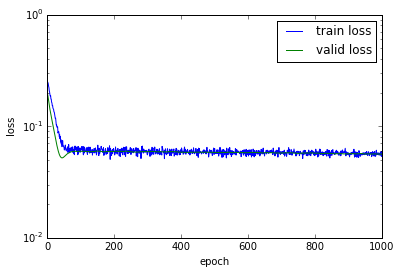

In [18]:
plot_loss(net49)

In [19]:
for i in range(5):
    X_test[:, i, :, :] = renormalize(X_test[:, i, :, :])
    
y_test = renormalize(y_test)

In [20]:
# Need to fix this since multioutput isn't working... y_abs_error should give
# back an array of floats.  Currently gives back single number.  Adding the term
# after "multioutput" should do it.

y_pred = net49.predict(X_test)
from sklearn.metrics import mean_absolute_error
y_abs_error = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
print(y_abs_error)

TypeError: mean_absolute_error() got an unexpected keyword argument 'multioutput'

In [21]:
#MEAN ABSOLUTE ERROR, not currently operational.
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(y_abs_error, log=True)

NameError: name 'y_abs_error' is not defined

In [28]:
# The closer to 0 this is, the better the prediction is!

from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred))
y_comp = np.hstack((y_test, y_pred))
print(y_comp)

0.0583791055709
[[ 0.45748757  0.43117908]
 [ 0.16787825  0.42866524]
 [ 0.13306707  0.41396449]
 [ 0.07092078  0.4018529 ]
 [ 0.77103797  0.42531208]
 [ 0.76574986  0.44125953]
 [ 0.31105993  0.43770015]
 [ 0.62654012  0.43676661]
 [ 0.37286932  0.4270171 ]
 [ 0.32438293  0.43049071]
 [ 0.39864235  0.43405197]
 [ 0.20001732  0.41642888]
 [ 0.04198151  0.39900649]
 [ 0.33109116  0.42679656]
 [ 0.37049864  0.42709707]
 [ 0.77743182  0.44077985]
 [ 0.42218195  0.43445994]
 [ 0.39797066  0.43516164]
 [ 0.23672646  0.42677588]
 [ 1.          0.44140209]
 [ 0.58273201  0.4380761 ]
 [ 0.53257227  0.43361993]
 [ 0.36687584  0.43388697]
 [ 0.17028028  0.42485663]
 [ 0.66521907  0.44122008]
 [ 0.6646085   0.43958553]
 [ 0.20589015  0.42647728]
 [ 0.05838608  0.4251085 ]
 [ 0.6571122   0.44001842]
 [ 0.04759623  0.44082403]
 [ 0.70848614  0.43932848]
 [ 0.1739792   0.42319988]
 [ 0.23321638  0.42791036]
 [ 0.80399048  0.43956077]
 [ 0.36761377  0.43137145]
 [ 0.14319815  0.4094615 ]
 [ 0.8490032

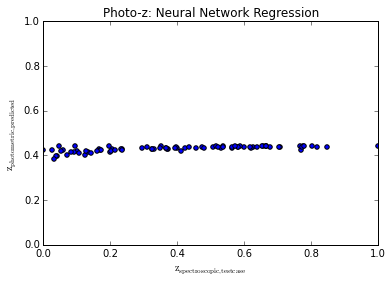

In [24]:
#Photo-z vs. Spec-z plot.  Maybe consider making this a hexbin plot?

fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(y_test, y_pred)
plt.title("Photo-z: Neural Network Regression")
plt.xlabel(r'$\mathrm{z_{spectroscopic, test case}}$')
plt.ylabel(r'$\mathrm{z_{photometric, predicted}}$')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

In [ ]:
#PHOTOZ VS. SPECZ plot HEXBIN VERSION.  
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hexbin(y_test, y_pred, gridsize = 20, cmap = plt.cm.BuGn)  #alternately could have plt.cm.viridis?
plt.title("Photo-z: Neural Network Regression")
plt.xlabel(r'$\mathrm{z_{spectroscopic, test case}}$')
plt.ylabel(r'$\mathrm{z_{photometric, predicted}}$')
plt.colorbar()

plt.show()

In [22]:
# Best possible score = 1.0, can be negative (model can be arbitrarily worse)
# coefficient of determination 
# how well future samples are likely to be predicted by the model

from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

0.138898249256


In [23]:
# Median absolute error regression loss
# Must be positive
# Best value is 0.0

from sklearn.metrics import median_absolute_error
print(median_absolute_error(y_test, y_pred))

0.168136272284


In [24]:
np.save("net49_pred.npy", y_pred)